outline:
```outline
1. Background
    Raster data cubes, vector data frames
    Why are dataframes limiting?
2. What are vector data cubes?
    Data cube model from raster data, geometries from vector data 
3. What can we do with vector data cubes?
    Question
    Data to answer it
    Combine different pieces of data
    Compute/visualize
4. Other fun things
5. Summary
    Introduce pt. 2

```

notes:
```{note} 
1. probably a bit too much text in background right now, is all that framing necessary? / just fix wordiness
2. threw in some illustrations for now as stand-ins, think about if they're helpful / which to use / maybe do some quick drawings? 
```
(notion outline/notes [here](https://www.notion.so/earthmover/Vector-data-cube-blog-post-outline-efef20437d7d44e6b046c3f4cf6b11cd))

# Introducing vector data cubes ! 

(add inline illustration of vector data cube near the top ? )

The Xarray ecosystem now supports vector data cubes :tada. Just like raster data such as satellite imagery and modelled climate data, geospatial datasets representing real-world features as points, lines and polygons are increasingly large, complex and multidimensional, pushing the limitations of existing tools for working with these data types. We've seen growing interest in multidimensional representations of vector data across the geospatial scientific community and are excited to announce the extension of the Xarray data model to support vector geometries. Vector data cubes enable new ways of representing and interacting with geospatial data, extending powerful Xarray features like label-based indexing, selection and computation to geometries. 

This blog post is geared toward Xarray users and analysts working with geospatial datasets. We will first introduce the concept of vector data cubes, discuss how they differ from existing tooling, and the analytical opportunities they create. Next, we will demonstrate how vector data cubes can be used to streamline and augment a scientific workflows: we will walk through an example of constructing a vector data cube by sampling ERA5 reanalysis data at a number of geometries representing areas of interest. [fix this wording]


## Background

(add illustration of data cube, data frame)

### Raster data cubes, vector data frames

The Python ecosystem has robust tools built to work with both raster and vector data. Geospatial raster data are typically stored as cubes, with dimensions such as `[x,y]` or `[longitude, latitude]` representing the spatial domain of the dataset. Raster data cubes frequently have a time dimension, representing physical observables (data variables) over both space and time. These data are typically stored on disk as array-based formats such as NetCDF or Zarr and software like [Xarray] offer powerful tools for processing and analyzing this data in Python. In contrast, geospatial vector data, which model real-world features like rivers, counties and buildings as geometry objects, are typically stored as dataframes and formatted on disk as shp or GeoJSON files. The [GeoPandas] library in Python extends the [Pandas] framework, representing vector data as dataframes that have additional functionality related to spatial operations and handling coordinate reference system information. 

This brief overview highlights a key difference between the traditional models of raster and vector data: raster data is viewed as a cube while vector data is discussed as a dataframe. Both of these are powerful and function formats, but they are optimized for different types of operations. For this reason, framing raster data as cubes and vector data as dataframes can influence both how we as analysts think about our data and the analytical questions we ask with it. 

As an example, let's consider what a dataframe means in the context of spatial data. A dataframe is a 'structure that organizes data into a 2-dimensional table of rows and columns' ([cite](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://www.databricks.com/glossary/what-are-dataframes&ved=2ahUKEwjCi-fT_JCHAxVrpo4IHcwxCJEQFnoECBIQAQ&usg=AOvVaw3eFEyiLJDe5f_dJhb5GALk)). In many cases, this is an ideal format for vector data, and tools like GeoPandas enable a range of spatial operations that are built on top of this model. `geopandas.GeoDataFrames` are similar to `pandas.DataFrames`: they have an index and a number of data columns, but they also have a geometry column which store `shapely` geometry objects. Users can efficiently store vector dataset with easily accessible attribute data and perform operations that generate knowledge about the relationships between spatial features and associated attribute data. [add transition sentence]

(old version of this section in notion)  

![geodataframe](geodataframe.png)

### Pushing the limits of data frames

Imagine we have a collection of weather stations located throughout a river basin. Each weather station records data such as temperature, windspeed, and relative humidity. These are stored in the `data` columns of a `geopandas.GeoDataFrame`, while the coordinates of each weather station are stored as Point geometries in the `geometry` column. From this table, we can quickly access a lot of information and ask questions such as how do temperatures vary across the elevation range covered by the weather stations, and where are windspeeds highest? But, each time the weather station records a measurement, we get a new set of data for each variable. Within the strucuture of the GeoDataFrame, how should that new data be incorporated? 

There are a number of strategies for organizing information in dataframes such as [wide form]() (the columns of this dataframe are the cross-join (add link) of the implicit dimensions of the dataset) and [long form]() (the number of columns is minimized while a row is added for every combination of dimensions) dataframes [cite]. These let the user store multidimensional data in a way that makes it easy to query and subset. However, the dataframe column structure is still fundamentally one-dimensional and these strategies involve duplicating data along either the column or row dimension. 

Returning to the weather station example, when we stack multiple temporal observations from weather stations into a dataframe, we've added a dimension to the data. By adding columns or adding rows to incorporate the new data, we are essentially looking for ways to represent additional dimensions within the structure of a dataframe. **Vector datasets are frequently treated as 'flat' or where the spatial dimension is the only required functional dimension; but what happens when vector datasets contain additional dimensions like time?** Contrast this to raster data cubes, where data is explicitly represented as multi-dimensional and popular tools and data models reflect this fundamental shape. **What would it look like, and how would our workflows change if vector data were represented by cube structures similarly to raster data?** [reword]

<figure style="text-align: center;">
    <p float="left" style="display: flex; justify-content: center;">
        <img src="raster_datacube_img.png" alt="Image 1" width="300" style="margin-right: 10px;" />
        <img src="vector_datacube_img.png" alt="Image 2" width="300" />
    </p>
    <figcaption>Example of a raster data cube (left) and vector data cube (right). The raster data cube has a gridded structure with latitude, longitude and time dimensions. The vector data cube has a dimension of geometries, a dimension of data variables and a time dimension.</figcaption>
</figure>

## What are vector data cubes? 

Vector data cubes are n-dimensional arrays where at least one dimension is made up of an array of geometries ([cite R spatial paper]()). Where the spatial domain of a raster object is a gridded extent (eg. `rdc = {'x': [0,1,2,3,4,5,6,7,8,9], 'y':[0,1,2,3,4,5,6,7,8,9]}`), the spatial domain of a vector data cube is an array of points, lines or polygons representing real-world features:
```html
vdc = {'counties':
[<POLYGON ((-95.343 48.547, -95.341  48.715, -95.095 48.912, ...>,
<POLYGON ((-118.851 47.95, -118.847 48.479, -118.87 48.647, ...>,
<POLYGON ((-117.438 48.044,-117.541 47.79,  -117.607 47.798,...>,
```

With vector data cubes, we can now work with **n-dimensional geometric datasets**! :start-struck

## What can we do with vector datasets? 

There are many exciting use-cases for vector data cubes. spend a few sentences listing, discussion.
To demonstrate how vector datacubes can be incorporated in scientific workflows, we will focus on one use-case: sampling modelled climate data at a number of points of interest. 

### Start with a question we'd like to answer
```{note}
I think take out this phrasing here and in later sections, unnecessary/ wordy
``` 
**How do temperature and windspeed co-vary in different cities across Europe?** (sub more interesting question). 

### How will we answer it? 
We can use climate model data to answer this question. Climate models produced massive datasets with a number of physical variables that expand our understanding of the climate system beyond what it is possible through direct monitoring and observation. [ERA5] is a dataset that provides estimates for a number (32!) of climate variables for the entire globe for every 6 hour window from 1959 to 2022. 

These are big files! Thankfully, we can access it from Google Cloud Storage without having to download the data to our local computer.

In [1]:
#imports 
import fsspec
import xarray as xr
from datasets import load_dataset
import pandas as pd
import geopandas as gpd
import cf_xarray
import xvec
import numpy as np
import shapely


In [3]:
fs = fsspec.filesystem('gs')
fs.ls('gs://gcp-public-data-arco-era5/ar/')


['gcp-public-data-arco-era5/ar/1959-2022-1h-240x121_equiangular_with_poles_conservative.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-1h-360x181_equiangular_with_poles_conservative.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-6h-128x64_equiangular_conservative.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-6h-128x64_equiangular_with_poles_conservative.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-6h-1440x721.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-6h-240x121_equiangular_with_poles_conservative.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-6h-512x256_equiangular_conservative.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-6h-64x32_equiangular_conservative.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-6h-64x32_equiangular_with_poles_conservative.zarr',
 'gcp-public-data-arco-era5/ar/1959-2022-full_37-1h-0p25deg-chunk-1.zarr-v2',
 'gcp-public-data-arco-era5/ar/1959-2022-full_37-6h-0p25deg-chunk-1.zarr-v2',
 'gcp-public-data-arco-era5/ar/1959-2022-full_37-6h-0p25deg_der

We will use an 'analysis-ready' dataset, which means that a lot of work preparing the dataset has been done for us. Read more about analysis ready data and ERA5 processing [here](). 

The ERA5 dataset is stored in Google Cloud Storage as a [Zarr]() datacube. Use Xarray to read it into python:

In [4]:
era5_ds = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/1959-2022-full_37-6h-0p25deg-chunk-1.zarr-v2',
    chunks={'time': 48},
    consolidated=True,
)

/home/emmamarshall/miniconda/envs/arraylake/lib/python3.11/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.27.0
  warnings.warn(


This is a ton of data! :dizzy_face

In [4]:
print(f'size: {era5_ds.nbytes / (1024 ** 4)} TiB')

size: 81.35224620026929 TiB


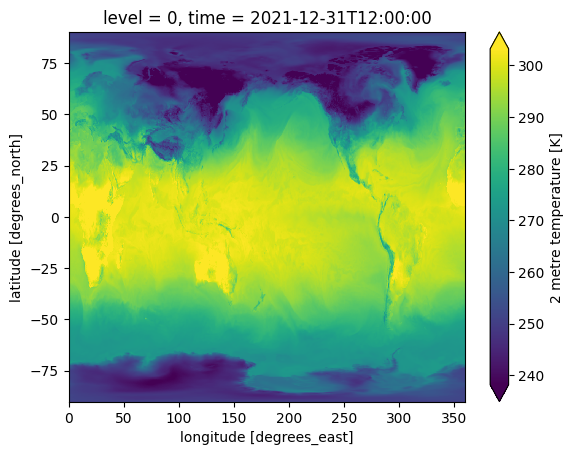

In [15]:
era5_ds.sel(level=0).isel(time=-2)['2m_temperature'].plot(robust=True);

## Subset to the data we need (using vector data)

ERA5 outputs are gridded datasets covering the entire globe. We only need data about cities in Europe, so continuing to store the global dataset is a pain and unnecessary. Let's extract point coordinate data for cities in Europe. 


In [2]:
cities = load_dataset('jamescalam/world-cities-geo',split='train')

Repo card metadata block was not found. Setting CardData to empty.


Construct a `pandas.DataFrame` of this data:

In [3]:
cities_df = pd.DataFrame({'city':cities['city'],
                          'country':cities['country'],
                          'region':cities['region'],
                          'latitude':cities['latitude'],
                          'longitude':cities['longitude'],
                          'continent':cities['continent'],
                         'x':cities['x'], 'y':cities['y'], 'z':cities['z']})

In [4]:
cities_df.head()

,city,country,region,latitude,longitude,continent,x,y,z
0,Kabul,Afghanistan,Southern Asia,34.516667,69.183334,Asia,1865.546410,4906.785732,3610.101297
1,Kandahar,Afghanistan,Southern Asia,31.610000,65.699997,Asia,2232.782352,4945.064043,3339.261233
2,Mazar-e Sharif,Afghanistan,Southern Asia,36.706944,67.112221,Asia,1986.505769,4705.517480,3808.088900
3,Herat,Afghanistan,Southern Asia,34.340000,62.189999,Asia,2454.269252,4652.966938,3593.897900
4,Jalalabad,Afghanistan,Southern Asia,34.420000,70.449997,Asia,1758.658611,4952.558405,3601.239528


ERA5 longitude values range from (0,360) rather than (-180,180); manipulate the 'cities' dataset to match this convention:

In [6]:
def lon_360(row):
    new_lon = ((360 + (row['longitude'] % 360)) % 360)
    return new_lon

In [7]:
cities_df['lon_360'] = cities_df.apply(lon_360, axis=1)

In [8]:
cities_eur = cities_df.loc[cities_df['continent'] == 'Europe']

In [9]:
cities_eur.head()

,city,country,region,latitude,longitude,continent,x,y,z,lon_360
84,Tirana,Albania,Southern Europe,41.327500,19.818890,Europe,4500.907258,1622.102741,4207.167403,19.818890
85,Durres,Albania,Southern Europe,41.323056,19.441389,Europe,4511.804644,1592.521568,4206.796276,19.441389
86,Elbasan,Albania,Southern Europe,41.112500,20.082222,Europe,4508.200233,1648.181036,4189.184997,20.082222
87,Vlore,Albania,Southern Europe,40.466667,19.489721,Europe,4569.228960,1617.126398,4134.814376,19.489721
88,Shkoder,Albania,Southern Europe,42.068283,19.512577,Europe,4457.868549,1579.715398,4268.670549,19.512577


Great, now we have a `pandas.DataFrame` of all of the 'cities' data. You can see we have location information in a number of columns, but right now its just being stored as any other variable. Convert to a `geopandas.GeoDataFrame` to represent the spatial information in the dataset as geometry objects.

In [24]:
cities_eur = gpd.GeoDataFrame(
    cities_eur,
    geometry = gpd.points_from_xy(cities_eur.longitude, cities_eur.latitude),
    crs = 'EPSG:4326'
)

Cool, now we can do things like this, and [much]() [more](). 

In [25]:
cities_eur.explore()

We can also take a look at the information stored in the attributes of the GeoDataFrame; it is all scalar, meaning that a dataframe is an ideal representation of this data. 

In [27]:
cities_eur.head()

,city,country,region,latitude,longitude,continent,x,y,z,lon_360,geometry
84,Tirana,Albania,Southern Europe,41.327500,19.818890,Europe,4500.907258,1622.102741,4207.167403,19.818890,POINT (19.81889 41.32750)
85,Durres,Albania,Southern Europe,41.323056,19.441389,Europe,4511.804644,1592.521568,4206.796276,19.441389,POINT (19.44139 41.32306)
86,Elbasan,Albania,Southern Europe,41.112500,20.082222,Europe,4508.200233,1648.181036,4189.184997,20.082222,POINT (20.08222 41.11250)
87,Vlore,Albania,Southern Europe,40.466667,19.489721,Europe,4569.228960,1617.126398,4134.814376,19.489721,POINT (19.48972 40.46667)
88,Shkoder,Albania,Southern Europe,42.068283,19.512577,Europe,4457.868549,1579.715398,4268.670549,19.512577,POINT (19.51258 42.06828)


To answer our question, we're going to need additional data (the climate variables produced by ERA5) attached to each of the locations represented in the GeoDataFrame. Importantly, we want to know how those variables change over time, meaning that our dataset will have a time dimension. 

### Assemble vector data cube
Now, let's take a look at how we can combine the climate variable time series data stored in the raster data cube with the spatial data stored in the vector data frame to construct a **vector data cube**.

First, create an `xr.Dataset` from the `gpd.GeoDataFrame`. This will create a datacube with a `geometry` dimension.

In [28]:
europe_ds = xr.Dataset(
    {
        'city':('geom',cities_eur['city']),
        'country':('geom',cities_eur['country']),
        'lat':('geom',cities_eur['latitude']),
        'lon':('geom', cities_eur['lon_360']),
    },
    coords= {'geom':cities_eur['geometry']},)

However, if you take a look at this object, you'll see that the index is still a PandasIndex, meaning that the data isn't being  treated as spatial data with a coordinate reference system etc. This is where [xvec]() comes in- Xvec is a library for working with vector data cubes in Xarray. Use Xvec's `set_geom_indexes()` method to convert the PandasIndex to special `GeometryIndex`. 

In [31]:
europe_ds.indexes

Indexes:
    geom     Index([   POINT (19.8188896 41.3275), POINT (19.4413891 41.3230556),
           POINT (20.082222 41.1125), POINT (19.4897213 40.4666667),
       POINT (19.5125771 42.0682829), POINT (19.5666676 40.7166667),
       POINT (20.7808342 40.6186111), POINT (19.9522228 40.7058333),
       POINT (19.7049999 40.9419444), POINT (19.5569439 41.1855556),
       ...
       POINT (38.6616669 48.5069444), POINT (33.6454582 49.0097264),
       POINT (33.5077782 48.3436111),  POINT (29.916666 50.0833333),
       POINT (33.3802795 46.7508333),  POINT (34.894165 50.3086111),
           POINT (39.7400017 48.295),      POINT (33.4666672 50.75),
       POINT (27.0666676 50.1833333), POINT (30.2166672 50.5666667)],
      dtype='object', name='geom', length=2844)

In [32]:
europe_ds = europe_ds.xvec.set_geom_indexes('geom',crs=4326)

`GeometryIndex` is similar to a `PandasIndex` but it allows for indexing and filtering based on geometries and has an attribute specifying the coordinate reference system of the index. 

In [49]:
europe_ds.indexes

Indexes:
    geom     Index([   POINT (19.8188896 41.3275), POINT (19.4413891 41.3230556),
           POINT (20.082222 41.1125), POINT (19.4897213 40.4666667),
       POINT (19.5125771 42.0682829), POINT (19.5666676 40.7166667),
       POINT (20.7808342 40.6186111), POINT (19.9522228 40.7058333),
       POINT (19.7049999 40.9419444), POINT (19.5569439 41.1855556),
       ...
       POINT (38.6616669 48.5069444), POINT (33.6454582 49.0097264),
       POINT (33.5077782 48.3436111),  POINT (29.916666 50.0833333),
       POINT (33.3802795 46.7508333),  POINT (34.894165 50.3086111),
           POINT (39.7400017 48.295),      POINT (33.4666672 50.75),
       POINT (27.0666676 50.1833333), POINT (30.2166672 50.5666667)],
      dtype='object', name='geom', length=2844)

### Combine modelled data and vector data

Now we'd like to attach the climate data to the 'cities' data cube. First, select only a single model level (read more [here]()).

In [50]:
era5_ds0 = era5_ds.sel(level=0) #take just near-surface mdel level
# when running this in hub, this produces a 4d objectstill w/ a levels dim, but all elements of levels dim = 0
# its 2x the size of this era5_ds0 object (12.5 tb)

In [51]:
era5_ds0

<xarray.Dataset> Size: 7TB
Dimensions:                                           (time: 92044,
                                                       latitude: 721,
                                                       longitude: 1440)
Coordinates:
  * latitude                                          (latitude) float32 3kB ...
    level                                             int64 8B 0
  * longitude                                         (longitude) float32 6kB ...
  * time                                              (time) datetime64[ns] 736kB ...
Data variables: (12/32)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 382GB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                           (time, latitude, longitude) float32 382GB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    2m_temperature                                    (time, latitude, longitude) float32 382GB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    geopotential                                      (time, latitude, longitude) float32 382GB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    ...                                                ...
    total_precipitation_6hr                           (time, latitude, longitude) float32 382GB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    type_of_high_vegetation                           (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    type_of_low_vegetation                            (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    u_component_of_wind                               (time, latitude, longitude) float32 382GB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    v_component_of_wind                               (time, latitude, longitude) float32 382GB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    vertical_velocity                                 (time, latitude, longitude) float32 382GB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>

In [54]:
print(f'size: {era5_ds0.nbytes / (1024 ** 4)} TiB')

size: 6.257914529454865 TiB


We will use the vector data cube we created, `europe_ds`, to interpolate the raster data cube onto the coordinate of the cities in our dataset. The ERA5 dataset is indexed along 'latitude' and 'longitude'  coordinates. To interpolate, we need to pass it information it understands about the locations of the cities (latitudes and longitudes). 

In [52]:
era5_europe_cities = era5_ds0.interp(latitude=europe_ds.lat, longitude=europe_ds.lon)

In [53]:
era5_europe_cities

<xarray.Dataset> Size: 19GB
Dimensions:                                           (time: 92044, geom: 2844)
Coordinates:
    level                                             int64 8B 0
  * time                                              (time) datetime64[ns] 736kB ...
    latitude                                          (geom) float64 23kB 41....
    longitude                                         (geom) float64 23kB 19....
  * geom                                              (geom) object 23kB POIN...
Data variables: (12/32)
    10m_u_component_of_wind                           (time, geom) float32 1GB dask.array<chunksize=(48, 2844), meta=np.ndarray>
    10m_v_component_of_wind                           (time, geom) float32 1GB dask.array<chunksize=(48, 2844), meta=np.ndarray>
    2m_temperature                                    (time, geom) float32 1GB dask.array<chunksize=(48, 2844), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (geom) float32 11kB dask.array<chunksize=(2844,), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (geom) float32 11kB dask.array<chunksize=(2844,), meta=np.ndarray>
    geopotential                                      (time, geom) float32 1GB dask.array<chunksize=(48, 2844), meta=np.ndarray>
    ...                                                ...
    total_precipitation_6hr                           (time, geom) float32 1GB dask.array<chunksize=(48, 2844), meta=np.ndarray>
    type_of_high_vegetation                           (geom) float32 11kB dask.array<chunksize=(2844,), meta=np.ndarray>
    type_of_low_vegetation                            (geom) float32 11kB dask.array<chunksize=(2844,), meta=np.ndarray>
    u_component_of_wind                               (time, geom) float32 1GB dask.array<chunksize=(48, 2844), meta=np.ndarray>
    v_component_of_wind                               (time, geom) float32 1GB dask.array<chunksize=(48, 2844), meta=np.ndarray>
    vertical_velocity                                 (time, geom) float32 1GB dask.array<chunksize=(48, 2844), meta=np.ndarray>
Indexes:
    geom     GeometryIndex (crs=EPSG:4326)

Cool, we went from a 3-d raster datacube with latitude and longitude dimensions to a 2-d datacube where the only spatial dimension is 'geometry' (each element of the geometry dimension is a different city from our original dataset). Our dataset is also **much** smaller now :thumbsup

In [55]:
print(f'size: {era5_europe_cities.nbytes / (1024 ** 4)} TiB')

size: 0.017142728822364006 TiB


Now, we have a 2-d dataset with **two indexes** meaning that we can query and manipulate `era5_europe_cities` along both the time and geometry dimensions.

In [56]:
era5_europe_cities

<xarray.Dataset> Size: 19GB
Dimensions:                                           (time: 92044, geom: 2844)
Coordinates:
    level                                             int64 8B 0
  * time                                              (time) datetime64[ns] 736kB ...
    latitude                                          (geom) float64 23kB 41....
    longitude                                         (geom) float64 23kB 19....
  * geom                                              (geom) object 23kB POIN...
Data variables: (12/32)
    10m_u_component_of_wind                           (time, geom) float32 1GB dask.array<chunksize=(48, 2844), meta=np.ndarray>
    10m_v_component_of_wind                           (time, geom) float32 1GB dask.array<chunksize=(48, 2844), meta=np.ndarray>
    2m_temperature                                    (time, geom) float32 1GB dask.array<chunksize=(48, 2844), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (geom) float32 11kB dask.array<chunksize=(2844,), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (geom) float32 11kB dask.array<chunksize=(2844,), meta=np.ndarray>
    geopotential                                      (time, geom) float32 1GB dask.array<chunksize=(48, 2844), meta=np.ndarray>
    ...                                                ...
    total_precipitation_6hr                           (time, geom) float32 1GB dask.array<chunksize=(48, 2844), meta=np.ndarray>
    type_of_high_vegetation                           (geom) float32 11kB dask.array<chunksize=(2844,), meta=np.ndarray>
    type_of_low_vegetation                            (geom) float32 11kB dask.array<chunksize=(2844,), meta=np.ndarray>
    u_component_of_wind                               (time, geom) float32 1GB dask.array<chunksize=(48, 2844), meta=np.ndarray>
    v_component_of_wind                               (time, geom) float32 1GB dask.array<chunksize=(48, 2844), meta=np.ndarray>
    vertical_velocity                                 (time, geom) float32 1GB dask.array<chunksize=(48, 2844), meta=np.ndarray>
Indexes:
    geom     GeometryIndex (crs=EPSG:4326)

In [57]:
cov = xr.cov(era5_europe_cities['2m_temperature'], era5_europe_cities['10m_u_component_of_wind'], dim='time')

In [ ]:
cov.plot()

- Show easy interoperability wtih geopandas, going from vector data cube -> geodataframe and use explore

- show saving to disk, reading to Xarray

## Summary

## Acknowledgments 

## References
(should the notebooks be included?)  
(still needs to be formatted)
- https://r-spatial.org/r/2022/09/12/vdc.html
- https://r-spatial.github.io/stars/articles/stars1.html#vector-data-cube-example
- https://discourse.pangeo.io/t/vector-data-cubes/2904
- https://notebooksharing.space/view/e9c4325e7ba9b921218d9780843f7961405c8494ded958b2d7f0a5749f917063#displayOptions=
- https://www.youtube.com/watch?v=2qnUDBwHFXc